\newpage

# Future frequency of threshold exceedance under different climate change scenarios

In this chapter the future frequency of threshold exceedance is determined. This is done using forcings based on different climate change scenarios, the Shared Socioeconomic Pathways (SSPs). SSPs are a set of narratives that outline potential future scenarios for human society, focussing on the use of fossil fuels and the social and economic factors that influence the consumption of fossil fuel (ClimateData.ca, 2025). The five main SSPs (Meinshausen et al., 2020) are being considered: 

| **Climate Scenario (SSP)** | **Description** |
|----------------------------|----------------------------------------------------------------|
| **SSP1-1.9**  | Sustainability scenario, aligns with a 1.5°C target under the Paris Agreement. |
| **SSP1-2.6**  | Sustainability scenario with a radiative forcing level of 2.6 W/m² by 2100. |
| **SSP2-4.5**  | "Middle of the road" scenario, assumes current development patterns continue, leading to a 4.5 W/m² forcing level by 2100. |
| **SSP3-7.0**  | Medium-high reference scenario in the 'regional rivalry' socio-economic family. |
| **SSP5-8.5**  | High-emission scenario in the 'fossil-fueled development' socio-economic family. |

*Table 4: The five main SSPs with descriptions (Meinshausen et al., 2020; ClimateData.ca, 2025)*

The future discharges are modelled with the HBV model using forcings from CMIP6 (Coupled Model Intercomparison Project) (Azote, 2025) as inputs. The forcings used in this research are generated by the German MPI model. Only one of the 25 ensembles is used, because in this research there is not enough time to look at all of the ensemblemembers. The used ensemble is called 'r1i1p1f1'. The nine parameters for the HBV model are calibrated in Chapter 4. 

## Historical Comparison

To be able to determine how well the model predicts discharge data using CMIP6, it is important to compare the model output to observation data. This shows us the uncertainty of the model. The distribution of this modelled discharge and the extrapolation can be seen in Figure 12.

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#niceties
from rich import print
import seaborn as sns
sns.set()

In [2]:
# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

In [3]:
camelsgb_id = "lamah_208082"

In [4]:
# historical data only available until 2014

experiment_start_date = "1981-08-01T00:00:00Z"
experiment_end_date = "2014-01-01T00:00:00Z"

In [5]:
cmip_dataset = {
    "dataset": "EC-Earth3",
    "project": "CMIP6",
    "grid": "gr",
    "exp": "historical",
    "ensemble": "r6i1p1f1",
}

In [6]:
forcing_path_caravan = Path.home() / "forcing" / camelsgb_id / "caravan"
forcing_path_caravan.mkdir(exist_ok=True, parents=True)

prepared_forcing_path_caravan_central = Path("/data/eurocsdms-data/forcing/lamah_208082/caravan")

# forcing_path_CMIP = Path.home() / "forcing" / camelsgb_id / "CMIP"  
forcing_path_CMIP = Path("/home/thirza/forcing/lamah_208082/CMIP")
forcing_path_CMIP.mkdir(exist_ok=True)

#prepared_forcing_path_ERA5_central = Path("/data/eurocsdms-data/forcing/camelsgb_73010/ERA5")

In [7]:
# # option two: load data that you or someone else generated previously
camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].load(Path("/home/thirza/forcing/lamah_208082/caravan"))

In [8]:
# print(camelsgb_forcing)

In [9]:
ds_forcing = xr.open_mfdataset([camelsgb_forcing['Q']])

In [10]:
# # option one: generate forcing:
# CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
#    dataset=cmip_dataset,
#    start_time=experiment_start_date,
#    end_time=experiment_end_date,
#    shape=camelsgb_forcing.shape,
# )

# # option two: load data that you or someone else generated previously
# #   this is needed because ERA5 forcing data is stored deep in a sub-directory
# load_location = prepared_forcing_path_caravan_central / "work" / "diagnostic" / "script" 
# ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(Path('/home/thirza/BEPproject/book/esmvaltool_output/ewcreppr6o7izt_20250320_150510/work/diagnostic/script'))

In [11]:
# print(CMIP_forcing)

In [12]:
#load calibration constants
#par_0 = np.loadtxt("/data/eurocsdms-data/calibration/calibration_" + camelsgb_id + ".csv", delimiter = ",")
# par_0 = np.loadtxt("/home/rhut/configFiles/calibration" + camelsgb_id + ".csv", delimiter = ",")
# par_0 = [1.46408246e-07, 8.68881909e-01, 1.02507886e+02, 2.20192834e+00,
#        1.05791079e+00, 1.84223360e-01, 1.15943798e+00, 1.59419229e+00,
#        5.97650513e-01]

par_0 = [7.70574780e-07, 1.32351315e+00, 1.00047603e+02, 3.89427105e+00,
       6.66366529e-01, 4.30576783e-02, 1.00508560e+00, 1.94023052e+00,
       4.58706486e-01]

param_names = ["Imax", "Ce", "Sumax", "Beta", "Pmax", "Tlag", "Kf", "Ks", "FM"]
# print(list(zip(param_names, np.round(par_0, decimals=3))))

In [13]:
#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5,  0])

In [14]:
model = ewatercycle.models.HBV(forcing=CMIP_forcing)

In [15]:
config_file, _ = model.setup(parameters=par_0, initial_storage=s_0)

In [16]:
model.initialize(config_file)

In [17]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))

In [18]:
model.finalize()

In [19]:
model_output = pd.Series(data=Q_m, name="Modelled discharge", index=time)

In [20]:
# model_output.plot()
# ds_forcing["Q"].plot(label="Observed discharge")
# plt.legend()
# plt.ylabel("Discharge (mm/d)")

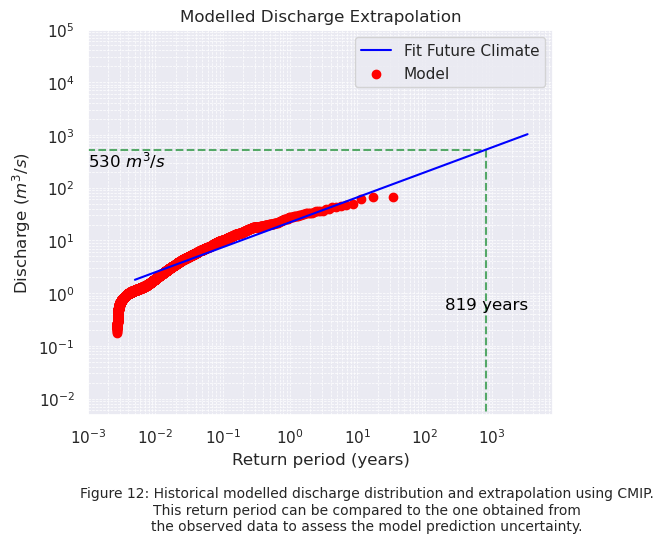

In [72]:
import scipy.stats as stats
import math
from scipy.optimize import curve_fit, fsolve
plt.figure(figsize=(6, 5))


catchment_area = ds_forcing["area"].values
df = pd.DataFrame(model_output)
model_data = df['Modelled discharge'] * catchment_area * 1000 / (24 * 60 * 60)
# Sort data from high to low
sorted_model_data = np.sort(model_data)[::-1]  # Sorteer aflopend


def power_law(x, a, b):
    return a * x ** b

def calculate_return_periods(sorted_model_data):
    n = len(sorted_model_data)
    rank = np.arange(1, n + 1)
    return_periods_days = (n + 1) / rank
    return_periods_years = return_periods_days / 365.25
    
    # Alleen de data voor returnperioden >= 0 behouden
    return_periods_years_subset = return_periods_years[return_periods_years >= 0]
    sorted_data_subset = sorted_model_data[return_periods_years >= 0]

    # Fit de power law functie
    params, _ = curve_fit(power_law, return_periods_years_subset, sorted_data_subset, maxfev=1000)
    a_opt, b_opt = params

    # Maak een fit voor de return period
    x_fit = np.logspace(np.log(min(sorted_model_data)+1e-1), np.log(max(return_periods_years_subset)), 1000)
    y_fit = power_law(x_fit, a_opt, b_opt)

    return x_fit, y_fit, a_opt, b_opt, return_periods_years_subset, sorted_data_subset

x_fit, y_fit, a_opt, b_opt, return_periods_years_subset, sorted_data_subset = calculate_return_periods(sorted_model_data)

def find_x_for_y(y_target, a, b):
    return (y_target / a) ** (1 / b)
y_target = 530
x_value = find_x_for_y(y_target, a_opt, b_opt)
# print(f"For a mean threshold value of {y_target} m3/s, the return period is {x_value:.3f} years for fit all data")

plt.hlines(y_target, xmin=0, xmax=x_value, colors='g', linestyles='dashed')
plt.vlines(x_value, ymin=0, ymax=y_target, colors='g', linestyles='dashed')
plt.text(x_value, 0.5, f'{x_value:.0f} years', ha='center', fontsize=12, color='black')  
plt.text(0.001, y_target, f'{y_target:.0f} $m^3/s$', va='top', fontsize=12, color='black')

y_target = 534
x_value = find_x_for_y(y_target, a_opt, b_opt)
# print(f"For a mean threshold value of {y_target} m3/s, the return period is {x_value:.3f} years for fit all data")

plt.plot(x_fit, y_fit, color='blue', label=f'Fit Future Climate')

plt.xscale('log')
plt.yscale('log')
plt.ylim(0.005, 100000)
plt.xlim(0.001, 8000)


plt.scatter(return_periods_years_subset, sorted_data_subset, label='Model', color='red')
plt.legend()
plt.xlabel('Return period (years)')
plt.ylabel('Discharge ($m^3/s$)')
plt.title('Modelled Discharge Extrapolation')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.text(0.6, -0.3, "Figure 12: Historical modelled discharge distribution and extrapolation using CMIP.\n" 
         "This return period can be compared to the one obtained from\n" "the observed data to assess the model prediction uncertainty.", 
         ha="center", fontsize=10, transform=plt.gca().transAxes);
plt.show();

In Figure 12 it can be seen that the mean treshold value of 530 m\textsuperscript{3}/s has a return period of 819 years. The extrapolated return period of the observed discharge determined in Chapter 3 amounted to 641 years. This means that the modelled and observed data result in a 27.7% difference. Therefore, with determining the return periods with different climate change scenarios, a model uncertainty of 27.7% is taken into account.

## Future Scenarios

Next, the future discharges for different climate change scenarios can be modelled using forcings from CMIP6. The future discharge is projected for a period of 40 years, from 2060 to 2100. The observation data is available for a period of about 40 years, so to be able to make a good comparison between the historical observation data and the future projected data, it is imported to use periods of equal lengths . This ensures that the comparison reflects differences in discharge rather than differences in trends caused by unequeal time spans. It eliminates the influence of longer-term variations or trends that may occur over extended periods. A period at the end of the century is used rather than the upcoming 40 years, since climate change projections are expected to get more extreme. By modeling future discharge under the most extreme expected climate scenarios, recommendations can be provided for the development of infrastructure designed for long-term resilience and protection.

In Figure 13 the future modelled discharges are plotted for the differenct climate change scenarios. In Figure 14 the distribution and extrapolation to the threshold values can be seen.

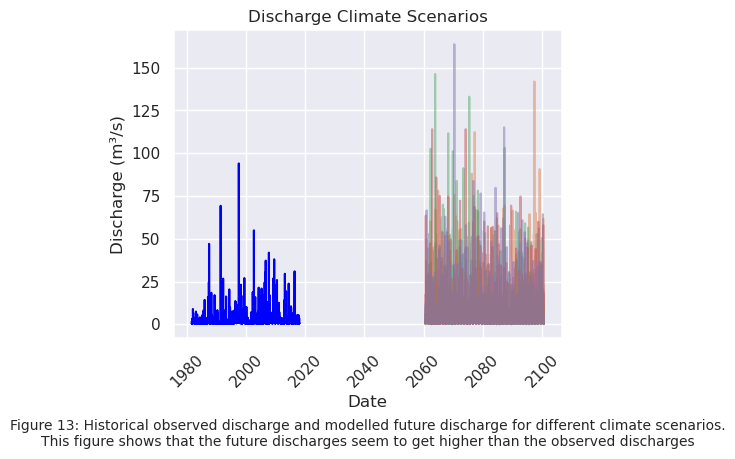

In [32]:
import pickle
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
def load_data(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(f)

file_paths = [
    "/home/thirza/BEPproject/book/EINDRAPPORT/climate_scenario119_data.pkl",
    "/home/thirza/BEPproject/book/EINDRAPPORT/climate_scenario126_data.pkl",
    "/home/thirza/BEPproject/book/EINDRAPPORT/climate_scenario245_data.pkl",
    "/home/thirza/BEPproject/book/EINDRAPPORT/climate_scenario370_data.pkl",
    "/home/thirza/BEPproject/book/EINDRAPPORT/climate_scenario585_data.pkl",
]
for file_path in file_paths:

    input_data = load_data(file_path)

    model_data = input_data['model_data']
    df = input_data['df']
    ds_forcing = input_data['ds_forcing']
    scenario_name = input_data['scenario_name']
    
    plt.plot(df.index, model_data, label=f'Modelled discharge ({scenario_name})', alpha=0.5)
catchment_area = ds_forcing["area"].values
(ds_forcing["Q"]* catchment_area * 1000 / (24 * 60 * 60)).plot(label="Observed discharge", color='blue')
plt.xlabel('Date')
plt.ylabel('Discharge (m³/s)')
plt.title('Discharge Climate Scenarios')
plt.xticks(rotation=45)  # Draai de datums voor betere leesbaarheid
# plt.legend()
plt.text(0.5, -0.35, "Figure 13: Historical observed discharge and modelled future discharge for different climate scenarios.\n"
         "This figure shows that the future discharges seem to get higher than the observed discharges", 
         ha="center", fontsize=10, transform=plt.gca().transAxes)
# plt.savefig("/home/thirza/BEPproject/book/EINDRAPPORT/grafiek119discharge.png", dpi=300)
plt.show()

In [30]:
# from PIL import Image as PILImage
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# fig, axs = plt.subplots(3, 2, figsize=(12, 12))
# axs = axs.flatten()

# img1 = mpimg.imread('grafiek119distribution.png')  
# img2 = mpimg.imread('grafiek126distribution.png')
# img3 = mpimg.imread('grafiek245distribution.png')  
# img4 = mpimg.imread('grafiek370distribution.png')
# img5 = mpimg.imread('grafiek585distribution.png')  


# # Voeg de afbeeldingen toe aan de subplots
# images = [img1, img2, img3, img4, img5]
# for i in range(5):
#     axs[i].imshow(images[i])
#     axs[i].axis('off')


# axs[5].axis('off') 

# fig.suptitle('Modelled Future Distribution and Extrapolation', fontsize=13)
# fig.text(0, -0.25, "Figure 16: Modelled discharge distribution and extrapolation for different climate change scenarios", 
#          ha="center", fontsize=15, transform=plt.gca().transAxes)
# plt.tight_layout()
# plt.show()

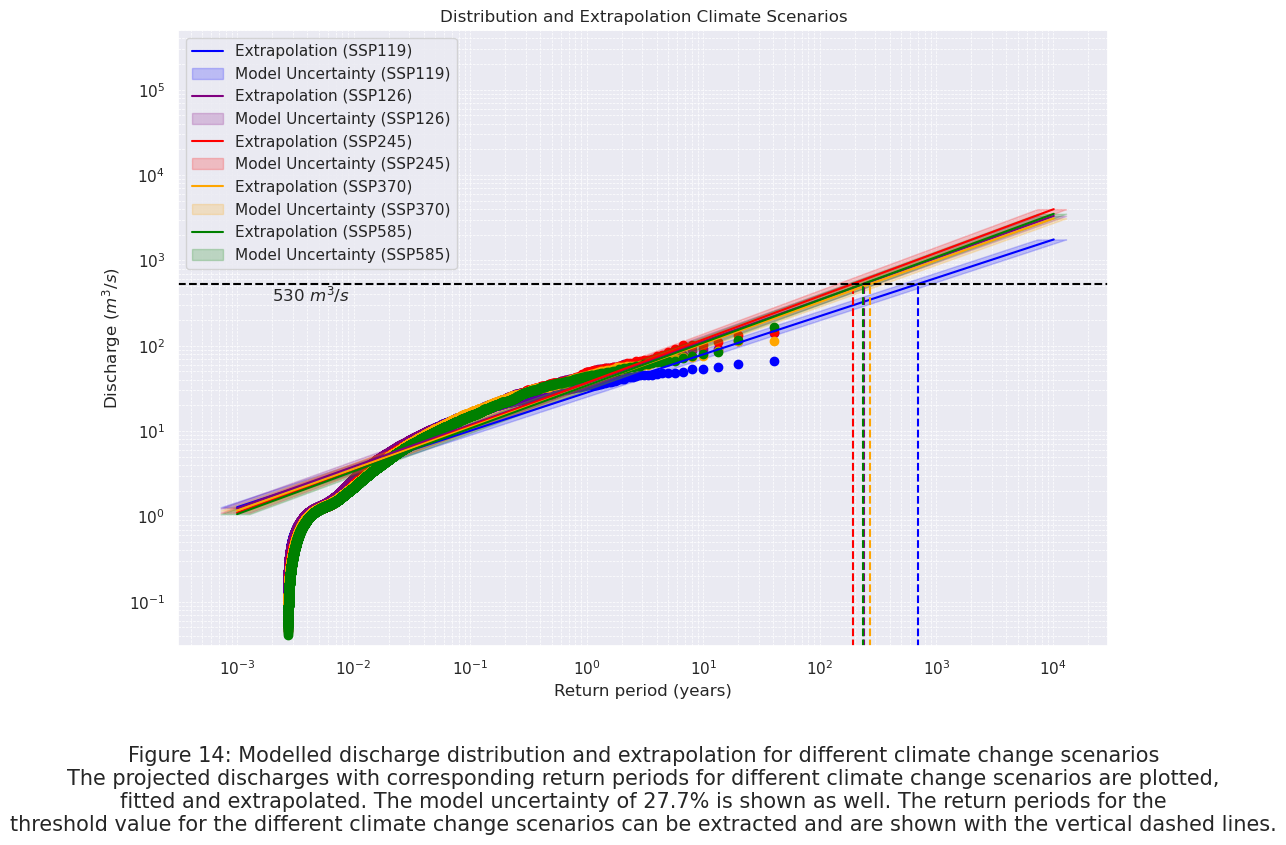

In [70]:
colors = ['blue', 'purple', 'red', 'orange', 'green']
plt.figure(figsize=(12, 8))

for idx, file_path in enumerate(file_paths):
    # Lees de data in
    input_data = load_data(file_path)
    
    
    return_periods_years_subset = input_data['return_periods_years_subset']
    sorted_data_subset = input_data['sorted_data_subset']
    x_fit = input_data['x_fit']
    y_fit = input_data['y_fit']
    x_lower_bound = input_data['x_lower_bound']
    x_upper_bound = input_data['x_upper_bound']
    scenario_name = input_data.get('scenario_name', f"Scenario {idx + 1}") 
    
    color = colors[idx % len(colors)]

    plt.scatter(return_periods_years_subset, sorted_data_subset, color=color)
    plt.plot(x_fit, y_fit, label=f"Extrapolation ({scenario_name})", color=color)
    plt.fill_betweenx(y_fit, x_lower_bound, x_upper_bound, alpha=0.2, label=f"Model Uncertainty ({scenario_name})", color=color)


    y_target = 530
    x_value = find_x_for_y(y_target, input_data['a_opt'], input_data['b_opt'])

    
    plt.vlines(x_value, ymin=0, ymax=y_target, colors=color, linestyles='dashed')
    # plt.text(x_value, -50, f'{x_value:.0f} years', ha='center', fontsize=12, color=color)
    # print(f"For a mean threshold value of {y_target} m3/s, the return period is {x_value:.3f} years for fit all data")
plt.axhline(y_target, linestyle='dashed', color='black')
plt.text(0.002, y_target, f'{y_target:.0f} $m^3/s$', va='top', fontsize=12)    
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.03, 500000)
# plt.yscale('log', nonpositive='clip')  # Als je de y-as logaritmisch wilt maken
plt.xlabel('Return period (years)')
plt.ylabel('Discharge ($m^3/s$)')
plt.title('Distribution and Extrapolation Climate Scenarios')
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.text(0.5, -0.3, "Figure 14: Modelled discharge distribution and extrapolation for different climate change scenarios\n"
         "The projected discharges with corresponding return periods for different climate change scenarios are plotted,\n"
         "fitted and extrapolated. The model uncertainty of 27.7% is shown as well. The return periods for the\n"
         "threshold value for the different climate change scenarios can be extracted and are shown with the vertical dashed lines.", 
         ha="center", fontsize=15, transform=plt.gca().transAxes)
plt.show()

## Conclusion

From Figure 14, it can be concluded that the future return periods for a discharge of 530 m\textsuperscript{3}/s considering the different climate change scenarios are:

| **Climate Scenario (SSP)** | **Return Period (Years)** | **Model Uncertainty Range (Years)** |
|----------------------------|--------------------------|-------------------------------------|
| **SSP119** | 697                      | 504 – 890                           |
| **SSP126** | 238                      | 172 – 292                           |
| **SSP245** | 191                  | 138 – 234                           |
| **SSP370** | 272                  | 197 – 334                           |
| **SSP585** | 235         | 170 – 288                           |

*Table 5: The SSPs with their return periods for the threshold value for flooding of the U4. The uncertainty range of 27.7% is calculated as well.*